<a href="https://colab.research.google.com/github/LongNguyen1984/TimeSeriesWithPython/blob/main/Factorymethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment
## Khảo sát dữ liệu

### Cài đặt pingouin

In [42]:
pip install pingouin

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
from abc import ABC, abstractmethod

import pingouin as pg

In [3]:
data_A = pd.read_csv('https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/aerodim.csv', sep = ';')

data_A.head()

,Poids,Taille,BMI,Age,Sexe,Hb,Diagnostic,GST,Volume,Surface,DmCO,Thickness,DLCO,FVC
0,53,165,19.467401,54,F,13.4,E,1.284048,7.0080,19.647869,450.315872,0.142701,6.767,2.30
1,92,170,31.833910,75,H,17.1,E,1.291861,3.7750,10.519710,72.271882,0.476060,19.146,3.04
2,69,186,19.944502,41,H,14.6,E,1.211214,7.7695,23.092705,372.142895,0.202952,29.047,5.72
3,60,160,23.437500,75,F,13.5,E,1.439790,4.3295,10.825326,89.206177,0.396893,14.943,2.57
4,72,172,24.337480,60,H,14.6,E,1.388885,5.5610,14.414152,180.833030,0.260699,13.888,4.36


In [4]:
data_A.Diagnostic.value_counts()

N    15
E    14
F     9
Name: Diagnostic, dtype: int64

###So sánh giữa 3 phân nhóm dựa trên chỉ số 'Thickness'

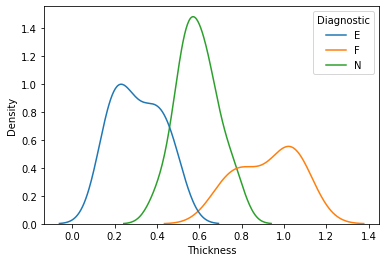

In [5]:
sns.kdeplot(data = data_A, x= 'Thickness', hue = 'Diagnostic')

###So sánh giữa 3 phân nhóm dựa trên chỉ số 'DmCO', phân bố vi phạm giả định chuẩn

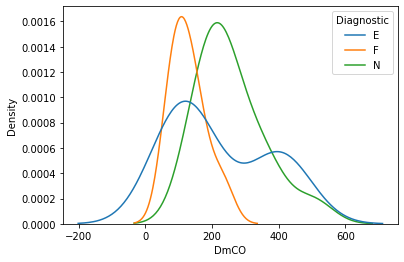

In [6]:
sns.kdeplot(data = data_A, x= 'DmCO', hue ='Diagnostic')

###So sánh giữa 3 phân nhóm dựa trên chỉ số 'Species', dữ liệu thỏa mãn cho phân bố chuẩn ANOVA

In [7]:
data_B = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/datasets/iris.csv', sep=',', decimal='.', index_col=0)

data_B.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,5.1,3.5,1.4,0.2,setosa
2,4.9,3.0,1.4,0.2,setosa
3,4.7,3.2,1.3,0.2,setosa
4,4.6,3.1,1.5,0.2,setosa
5,5.0,3.6,1.4,0.2,setosa


In [15]:
data_B['Species'].value_counts()

versicolor    50
virginica     50
setosa        50
Name: Species, dtype: int64

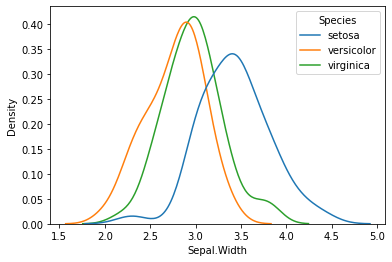

In [9]:
sns.kdeplot(data = data_B, x = 'Sepal.Width', hue='Species')

## Triển khai
Sơ đồ UML của hệ thống như sau:

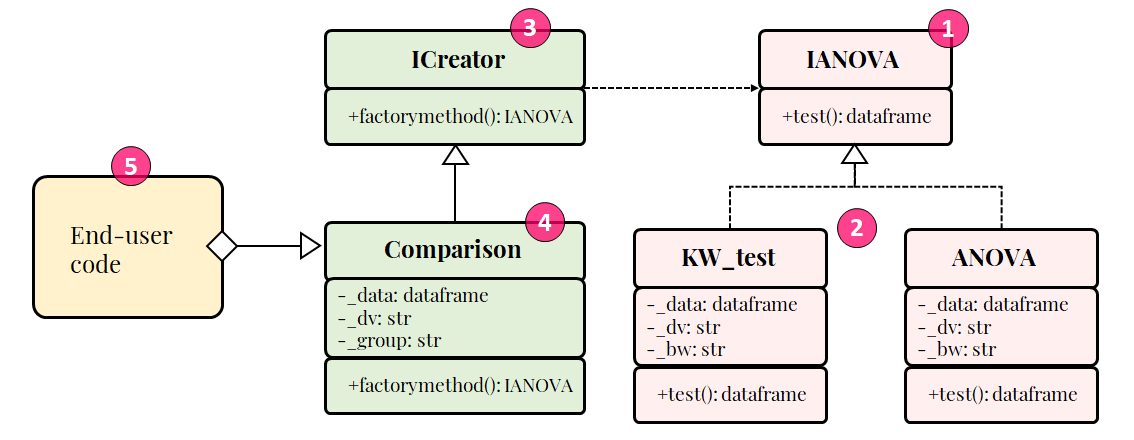

In [19]:
class IANOVA(ABC):

  @abstractmethod
  def test(self):
    pass

In [44]:
class ANOVA(IANOVA):
  def __init__(self, data:pd.DataFrame, dv:str, bw:str):
    self.name = 'Parametric ANOVA'
    self._data = data
    self._dv = dv
    self._bw = bw
  def test(self) -> pd.DataFrame:
    return pg.parametric.anova(data = self._data,
                               dv = self._dv,
                               between =self._bw)

In [45]:
class KW_test(IANOVA):
  def __init__(self, data:pd.DataFrame, dv:str, bw:str):
    self.name = 'Kruskal-Wallis test'
    self._data = data
    self._dv = dv
    self._bw = bw
  def test(self) -> pd.DataFrame:
    return pg.nonparametric.kruskal(data = self._data,
                                    dv = self._dv,
                                    between = self._bw)

## Tạo Creator interface là ICreator và class Comparison kế thừa ICreator, sau đó override method factory_method để thực hiện kiểm tra giả định phân phối và gọi product tương ứng

In [46]:
class ICreator(ABC):
    
    @abstractmethod
    def factory_method(self):
        pass

In [47]:
class Comparison(ICreator):
    
    def __init__(self, 
                 data: pd.DataFrame, 
                 dv: str, 
                 group: str):
        self._data = data
        self._dv = dv
        self._group = group
    
    def factory_method(self) -> IANOVA:
        
        # Normality check
        nc = pg.normality(data = self._data, 
                          dv = self._dv, 
                          group = self._group)
        
        normality = all(nc.normal.values)
        #Sample_size check
        large_size = all(self._data.groupby(self._group)[self._dv].agg(lambda x: x.shape[0]).values > 10)
        
        if (normality & large_size):
            print('Dữ liệu phân bố chuẩn và đủ lớn, dùng ANOVA')
            return ANOVA(data = self._data, dv = self._dv, bw = self._group)
        else:
            print('Dữ liệu không thỏa giả định ANOVA, dùng Kruskal-Wallis')
            return KW_test(data = self._data, dv = self._dv, bw = self._group)

### Sử dụng

In [50]:
CASE_A = Comparison(data = data_A, dv = 'Thickness', group = 'Diagnostic')

CASE_A.factory_method().test()

Dữ liệu không thỏa giả định ANOVA, dùng Kruskal-Wallis


,Source,ddof1,H,p-unc
Kruskal,Diagnostic,2,31.130711,1.738009e-07


In [52]:
CASE_B = Comparison(data = data_A, dv = 'DmCO', group = 'Diagnostic')

CASE_B.factory_method().test()

Dữ liệu không thỏa giả định ANOVA, dùng Kruskal-Wallis


,Source,ddof1,H,p-unc
Kruskal,Diagnostic,2,8.929143,0.01151


In [53]:
CASE_C = Comparison(data = data_B, dv = 'Sepal.Width', group = 'Species')

CASE_C.factory_method().test()

Dữ liệu phân bố chuẩn và đủ lớn, dùng ANOVA


,Source,ddof1,ddof2,F,p-unc,np2
0,Species,2,147,49.16004,4.492017e-17,0.400783
